<a href="https://colab.research.google.com/github/joshualawrencemorgan/CS5265-Foundations-of-Machine-Learning/blob/add_data/Capital_Bikeshare_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital Bikeshare Membership Prediction and Rider Preference

## Background
Bikeshare programs in large cities offer a cost-effective and environmentally friendly mode of transportation for citizens and tourists. The bike docks that are integral to these programs can collect several data points about each ride. Research has been conducted by the [Department of Transportation](https://data.bts.gov/stories/s/Summary-of-Docked-Bikeshare-Trips-by-System-and-Ot/7fgy-2zkf/) on the total usage of bikeshare programs and the membership numbers of the program, but extensive research into the differences between casual and member riders has not been conducted. I want to use the data provided by the bikeshare program in Washington, D.C., Capital Bikeshare, to build a model that can predict, based on the characteristics of a ride, whether that ride was made by a member (a rider with an annual subscription) or a non-member.

## Project Description
This project seeks to learn more about the behaviors of bikeshare users by creating a membership prediction model for Capital Bikeshare (CaBi). The analysis is conducted on user trip data from [July 2023 rides](https://s3.amazonaws.com/capitalbikeshare-data/index.html) provided by Capital Bikeshare. I anticipate that the results of the model will highlight key differences in ridership behaviors such as time of ride, bike type, and duration of ride that could help CaBi better serve its customers and maximize profitability.

## Performance Metrics

Accuracy - Can the model correctly predict whether a ride was taken by a member or a casual rider? This will involve training against a dataset and comparing the model's determination against the data from Capital Bikeshare. Results will be recorded into a confusion matrix and classification accuracy will calculated using the function below.

| Actual | Predicted |
|---|---|
| Positive | True Positive (TP) | False Positive (FP) |
| Negative | False Negative (FN) | True Negative (TN) |

$$
Accuracy =\frac{TruePositive+TrueNegative}{𝑇rue𝑃ositive+𝐹alse𝑃ositive+𝐹alse𝑁egative+𝑇rue𝑁egative}
$$

Characteristics - Which characteristics of a ride are more important for members? Using the model, is it possible to identify attributes of a ride that are more common among members? Knowledge of these attributes could help CaBi change its pricing model to provide the best service for its customers while also maximizing revenue.

## Feature Engineering

The data provided by Capital Bikeshare requires a serious amount of cleaning and feature engineering to provide a more holistic understanding of the ride data. Here I propose 3 features to be engineered.

### Duration Feature
Using pandas to format the current features 'started_at' and 'ended_at' in to a datetime will allow for the creation of a duration feature that will provide the more context to each ride.
```python
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
```

### Day of the week Feature
Extrapolating what day of the week the ride was on will help our machine learning process identify patterns across multiple weeks. 'day_of_week' is stored as an enum with sunday being 0 and saturday being 6.
```python3
df['day_of_week'] = df['started_at'].dt.dayofweek
```

### Distance Feature
Determining the actual path that bikes took would require extremely expensive GPS tracker to be installed and maintained in each bike. This feature seeks to provide a suitable alternative by calculating the geographical distance between where the bike was checked out and where the bike started. This will provide even more context to each ride and help provide more insight into the behaviour of riders.

```python3
df['distance'] = df.apply(lambda row: geodesic((row['start_lat'], row['start_lng'])
```

## Initial Pipeline

Before starting to answer questions about the data some cleaning must be done.

The new features `distance` and `duration` make it easy to spot anamolies in the data. Through user error or sensor error a ride with no distance or duration could be recorded. These can be removed using the following:
```python3
df = (df[df['distance'] > 0])
df = (df[df['duration'] > 0])
```

The Capital Bikeshare dataset provides an ambudance of data. In order to be able to perform the task of this project in a timely manner the dataset should be reduced to two weeks. The last two weeks of July were chosen to avoid holidays skewing data though further investigation could reveal valuable information.
```python3
df = df[df['started_at'].between('2023-07-16', '2023-07-29')]
df.to_csv('Capital-Bikeshare-Dataset-cleaned.csv')


##Exploratory Data Analysis

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/joshualawrencemorgan/CS5265-Foundations-of-Machine-Learning/main/Capital_Bikeshare_cleaned.csv')

df.describe()

,Unnamed: 0,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,duration,day_of_week,distance
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,243567.058140,31370.425520,31373.441680,38.902265,-77.032877,38.901190,-77.032449,1102.845060,2.871340,1.178166
std,137734.530487,279.694166,281.204661,0.025496,0.034616,0.025306,0.034304,3410.417946,1.969869,0.892747
min,2.000000,30200.000000,30200.000000,38.782633,-77.368473,38.782633,-77.368416,1.000000,0.000000,0.000185
25%,113506.500000,31211.000000,31214.000000,38.890496,-77.044710,38.890461,-77.044780,389.000000,1.000000,0.585060
50%,258269.000000,31280.000000,31280.000000,38.902674,-77.031737,38.902000,-77.031617,657.000000,3.000000,0.954958
75%,360902.000000,31609.000000,31610.000000,38.912659,-77.013769,38.911268,-77.013500,1121.000000,4.000000,1.523398
max,466415.000000,33200.000000,33200.000000,39.125828,-76.844604,39.125828,-76.825535,421859.000000,6.000000,18.536506


Question 1: What proportion of rides are by members?

([<matplotlib.patches.Wedge at 0x79d27693b730>,
 [Text(-0.326044941332956, 1.0505687489313535, 'member'),
  Text(0.32604484297160924, -1.0505687794578795, 'casual')])

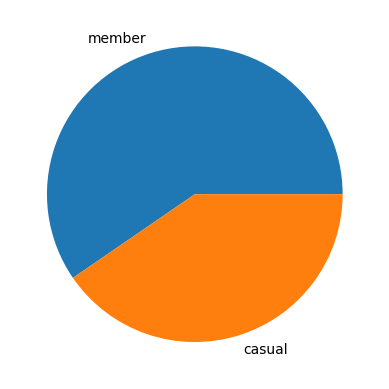

In [59]:
ride_counts = df['member_casual'].value_counts()
plt.pie(ride_counts, labels=ride_counts.index)

Question 2: Which group of users is more likely to use electric bikes?

([<matplotlib.patches.Wedge at 0x79d276705450>,
 [Text(-0.8074262203634074, 0.7470360758823248, 'classic_bike'),
  Text(0.720156735041416, -0.8314891923377525, 'electric_bike'),
  Text(1.0932962238374142, -0.12125744077313745, 'docked_bike')])

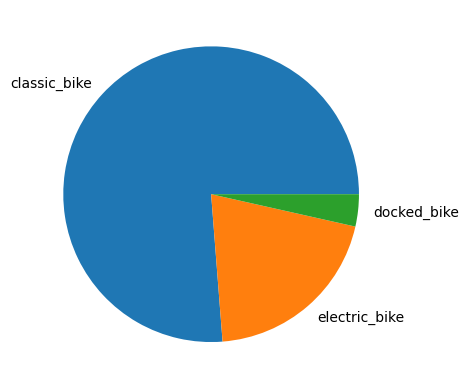

In [68]:
type_counts = df['rideable_type'].value_counts()
plt.pie(type_counts, labels=type_counts.index)

Question 3: Which group of riders, member or nonmembers, is more likely to travel a further distance?

<Axes: xlabel='day_of_week', ylabel='distance'>

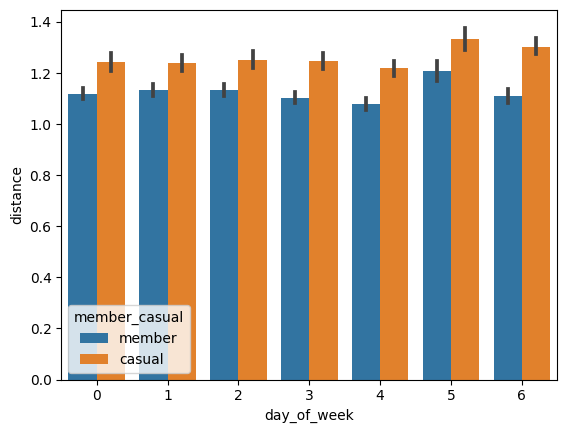

In [ ]:
sns.barplot(x = 'day_of_week', y = 'distance', hue = 'member_casual', data = df)


Question 2: Which group of riders, member or nonmembers, is more likely to take a short trip (< 10 minutes)?

<Axes: xlabel='day_of_week', ylabel='duration'>

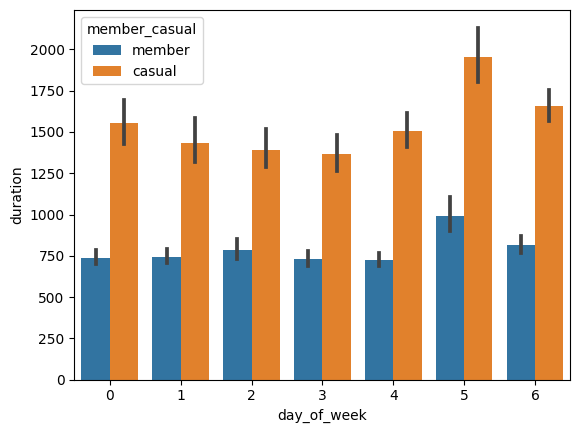

In [ ]:
sns.barplot(x = 'day_of_week', y = 'duration', hue = 'member_casual', data = df)


Question 3: Are members more likely to use the bikes early in the morning than non-members?

<Axes: xlabel='hour', ylabel='count'>

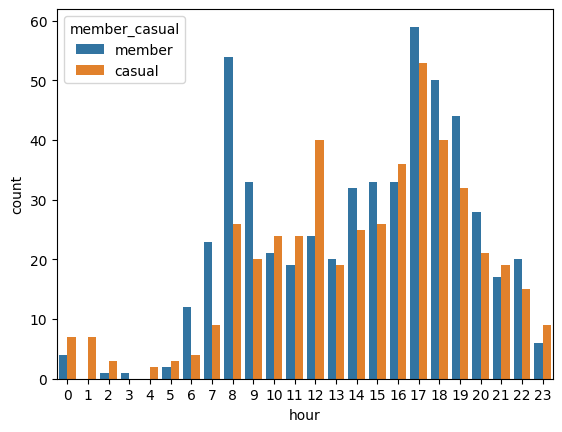

In [57]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['duration'] = pd.to_datetime(df['duration'], unit='s')

some = df.sample(1000)
some['hour'] = some['started_at'].dt.hour
some.groupby('hour')['member_casual'].count()
sns.countplot(x='hour', hue='member_casual', data=some)

##Train test split
based on the metadata (such as size
and target class distribution) of your dataset, briefly outline your train/test percent split. Include the percentage for your golden holdout set if you plan to leave one out

##Model fitting and evaluation
list 1-3 assumptions you have about feature importance or how you anticipate your model’s performance will be